# Explanation
Samples are generated as a "poisson random walk" where the CN in first state is random poisson, and then the following CN=CN+jump where jump is a poisson random variable. Two clusters were simulated using different jump, initialization parameters and then they were clustered.

/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


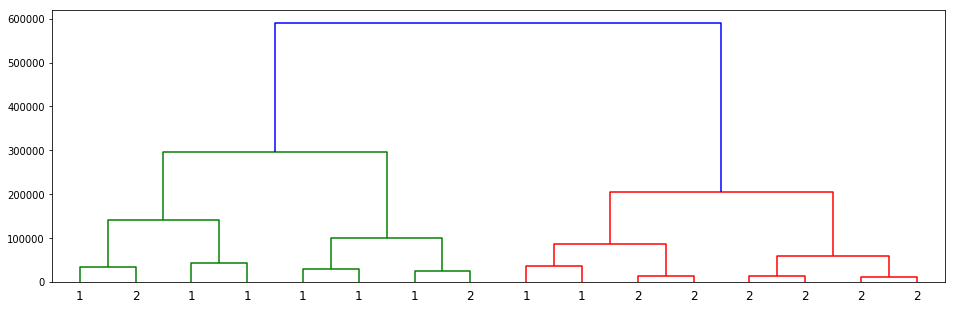

In [3]:
import scgenome.simulation as sim
import numpy as np
import pandas as pd
from IPython.display import display
from scgenome import cncluster
from scgenome.utils import cn_mat_to_cn_data, cn_mat_as_df
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

NUM_SAMPLE = 8
NUM_BIN = 500
CHR_NAMES = ["1","2"]
max_cn=7

cluster1 = sim.cn_mat_poisson(NUM_SAMPLE, NUM_BIN, init_lambda=1., jump_lambda=1, seed=None, max_cn=max_cn)
cluster2 = sim.cn_mat_poisson(NUM_SAMPLE, NUM_BIN, init_lambda=3., jump_lambda=0.1, seed=None, max_cn=max_cn)

clst1_cell_ids = [f"cl1_cell{i}" for i in range(cluster1.shape[0])]
clst2_cell_ids = [f"cl2_cell{i}" for i in range(cluster1.shape[0])]

cn_mat = np.concatenate([cluster1, cluster2])
cell_ids = clst1_cell_ids + clst2_cell_ids

df_cn_mat = cn_mat_as_df(cn_mat,CHR_NAMES)
cn_data = cn_mat_to_cn_data(df_cn_mat, cell_id_vals=cell_ids)
cn_data["cluster_id"] = cn_data["cell_id"].str.split("_",expand=True).iloc[:,0]
cn_data["copy2"] = cn_data["copy"] + np.absolute(np.random.normal(size=cn_data.shape[0], scale=0.3))
cn_data.columns = ["chr", "bin", "cell_id", "state", "start", "end", "cluster_id", "copy"]

tlinkage, root, cl_cell_ids = cncluster.bayesian_cluster(cn_data, n_states=max_cn, value_ids=["copy"])

plinkage = tlinkage[["i","j","r_merge","merge_count"]]
plinkage["r_merge"] = plinkage["r_merge"].astype("float")
plinkage["dist"] = -1 * plinkage["r_merge"]
plot_data = plinkage[["i","j","dist","merge_count"]].to_numpy().astype("float")

cl_cell_ids = cl_cell_ids.str[2]
fig = plt.figure(figsize=(16, 5))
dend = dendrogram(plot_data, labels=cl_cell_ids)

# Analysis
Doesn't work too well. The y-axis is `-marginal_log_likelihood` and the values are quite high so I question it. Should be getting good clustering

In [2]:
clustering = pd.DataFrame()
clustering["sample_inds"] = list(range(cn_mat.shape[0]))
clustering["cell_id"] = cell_ids
clustering["exp_cl"] = clustering["cell_id"].str[2]

left_samples = [x.sample_inds[0] for x in root.left_child.get_leaves()]
right_samples = [x.sample_inds[0] for x in root.right_child.get_leaves()]


def fn(ind):
    if ind in left_samples:
        return "1"
    elif ind in right_samples:
        return "2"
clustering["obs_cl"] = clustering["sample_inds"].apply(fn)

def get_prop_correct(clustering):
    return max((clustering["exp_cl"] == clustering["obs_cl"]).value_counts() / clustering.shape[0])

print(f"proportion clustering: {get_prop_correct(clustering)}")

proportion clustering: 0.625


# Repeating over many trials

In [7]:
NUM_TRIALS = 10
NUM_SAMPLE = 8
NUM_BIN = 500
CHR_NAMES = ["1","2"]
MAX_CN=7

def simulate_bayes_cluster(df, num_sample=NUM_SAMPLE, num_bin=NUM_BIN, chr_names=CHR_NAMES, max_cn=MAX_CN):
    cluster1 = sim.cn_mat_poisson(num_sample, num_bin, init_lambda=1., jump_lambda=1, seed=None, max_cn=max_cn)
    cluster2 = sim.cn_mat_poisson(num_sample, num_bin, init_lambda=3., jump_lambda=0.1, seed=None, max_cn=max_cn)

    clst1_cell_ids = [f"cl1_cell{i}" for i in range(cluster1.shape[0])]
    clst2_cell_ids = [f"cl2_cell{i}" for i in range(cluster1.shape[0])]

    cn_mat = np.concatenate([cluster1, cluster2])
    df["cn_mat"] = cn_mat
    cell_ids = clst1_cell_ids + clst2_cell_ids

    df_cn_mat = cn_mat_as_df(cn_mat, chr_names)
    cn_data = cn_mat_to_cn_data(df_cn_mat, cell_id_vals=cell_ids)
    cn_data["cluster_id"] = cn_data["cell_id"].str.split("_",expand=True).iloc[:,0]
    cn_data["copy2"] = cn_data["copy"] + np.absolute(np.random.normal(size=cn_data.shape[0], scale=0.3))
    cn_data.columns = ["chr", "bin", "cell_id", "state", "start", "end", "cluster_id", "copy"]

    tlinkage, root, cl_cell_ids = cncluster.bayesian_cluster(cn_data, n_states=max_cn, value_ids=["copy"])

    plinkage = tlinkage[["i","j","r_merge","merge_count"]]
    plinkage["r_merge"] = plinkage["r_merge"].astype("float")
    plinkage["dist"] = -1 * plinkage["r_merge"]
    plot_data = plinkage[["i","j","dist","merge_count"]].to_numpy().astype("float")
    df["plot_data"] = plot_data
   
    clustering = pd.DataFrame()
    clustering["sample_inds"] = list(range(cn_mat.shape[0]))
    clustering["cell_id"] = cell_ids
    clustering["exp_cl"] = clustering["cell_id"].str[2]
    df["clustering"] = clustering

    left_samples = [x.sample_inds[0] for x in root.left_child.get_leaves()]
    right_samples = [x.sample_inds[0] for x in root.right_child.get_leaves()]

    def fn(ind):
        if ind in left_samples:
            return "1"
        elif ind in right_samples:
            return "2"
    clustering["obs_cl"] = clustering["sample_inds"].apply(fn)

    prop_correct = get_prop_correct(clustering)
    
    df["prop_correct"] = prop_correct    
    return df

sims = pd.DataFrame(list(range(NUM_TRIALS)), columns=["id"])
sims = sims.apply(simulate_bayes_cluster, axis=1)

/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,id,cn_mat,plot_data,clustering,prop_correct
0,0,"[[1, 0, 0, 0, 1, 1, 2, 2, 2, 2, 3, 6, 7, 5, 7,...","[[9.0, 15.0, 13081.071705814178, 2.0], [8.0, 1...",sample_inds cell_id exp_cl obs_cl 0 ...,0.8125
1,1,"[[1, 0, 0, 0, 2, 2, 2, 4, 4, 2, 1, 0, 0, 0, 0,...","[[11.0, 15.0, 12561.464239198434, 2.0], [8.0, ...",sample_inds cell_id exp_cl obs_cl 0 ...,0.7500
2,2,"[[0, 1, 4, 4, 3, 4, 5, 6, 7, 7, 7, 7, 7, 7, 7,...","[[11.0, 14.0, 19178.746871580268, 2.0], [16.0,...",sample_inds cell_id exp_cl obs_cl 0 ...,0.7500
3,3,"[[2, 1, 3, 3, 2, 1, 0, 2, 1, 0, 0, 1, 3, 3, 4,...","[[8.0, 13.0, 13415.902304800806, 2.0], [9.0, 1...",sample_inds cell_id exp_cl obs_cl 0 ...,0.7500
4,4,"[[0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 1, 0, 0, 0, 0,...","[[8.0, 11.0, 18754.41220305837, 2.0], [10.0, 1...",sample_inds cell_id exp_cl obs_cl 0 ...,0.6250


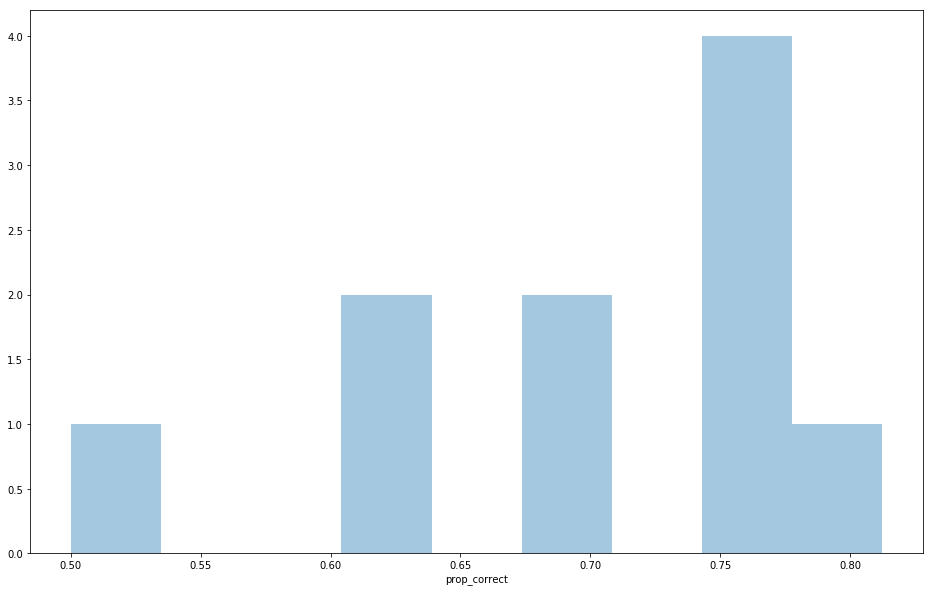

In [8]:
import seaborn as sns
display(sims.head())
fig = plt.figure(figsize=(16, 10))
sns.distplot(sims["prop_correct"], kde=False, bins=9)

/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,i,j,r_merge,dist,merge_count
0,13,15,-2326.720237,2326.720237,2
1,9,11,-4630.805200,4630.805200,2
2,17,10,-6093.020118,6093.020118,3
3,12,16,-7740.667277,7740.667277,3
4,4,14,-11851.481245,11851.481245,2
5,2,20,-12693.526106,12693.526106,3
6,18,19,-17063.230242,17063.230242,6
7,0,21,-18880.934866,18880.934866,4
8,5,7,-19755.869528,19755.869528,2
9,1,24,-24768.890709,24768.890709,3


,chr,bin,cell_id,state,start,end,cluster_id,copy
0,1,0,cl1_cell0,1,0,9,cl1,1.125027
1,1,1,cl1_cell0,0,10,19,cl1,0.016880
2,1,2,cl1_cell0,0,20,29,cl1,0.640859
3,1,3,cl1_cell0,0,30,39,cl1,0.492081
4,1,4,cl1_cell0,0,40,49,cl1,0.538031


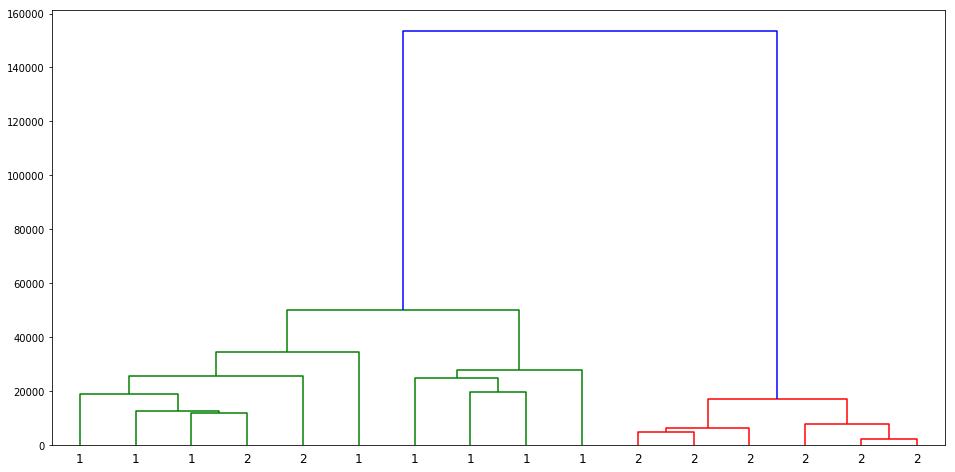

In [4]:
import scgenome.simulation as sim
import numpy as np
import pandas as pd
from IPython.display import display
from scgenome import cncluster
from scgenome.utils import cn_mat_to_cn_data, cn_mat_as_df
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

NUM_SAMPLE = 8
NUM_BIN = 300
CHR_NAMES = ["1","2"]
ALPHA=0.05
MAX_CN=7
NOISE_SEED=2

cluster1 = sim.cn_mat_poisson(NUM_SAMPLE, NUM_BIN, init_lambda=1., jump_lambda=1, seed=1, max_cn=MAX_CN)
cluster2 = sim.cn_mat_poisson(NUM_SAMPLE, NUM_BIN, init_lambda=3., jump_lambda=0.1, seed=3, max_cn=MAX_CN)

clst1_cell_ids = [f"cl1_cell{i}" for i in range(cluster1.shape[0])]
clst2_cell_ids = [f"cl2_cell{i}" for i in range(cluster1.shape[0])]

cn_mat = np.concatenate([cluster1, cluster2])
cell_ids = clst1_cell_ids + clst2_cell_ids

df_cn_mat = cn_mat_as_df(cn_mat,CHR_NAMES)
cn_data = cn_mat_to_cn_data(df_cn_mat, cell_id_vals=cell_ids)
cn_data["cluster_id"] = cn_data["cell_id"].str.split("_",expand=True).iloc[:,0]
if NOISE_SEED is not None:
    np.random.seed(NOISE_SEED)
cn_data["copy2"] = cn_data["copy"] + np.absolute(np.random.normal(size=cn_data.shape[0], scale=0.3))
cn_data.columns = ["chr", "bin", "cell_id", "state", "start", "end", "cluster_id", "copy"]

tlinkage, root, cl_cell_ids = cncluster.bayesian_cluster(cn_data, n_states=MAX_CN, value_ids=["copy"], alpha=ALPHA)

from scipy.stats import rankdata

plinkage = tlinkage[["i","j","r_merge","merge_count"]]
plinkage["r_merge"] = plinkage["r_merge"].astype("float")
if(plinkage["r_merge"].min() < 0):
    plinkage["dist"] = rankdata(-1*plinkage["r_merge"])
    #plinkage["dist"] = plinkage["r_merge"] +  -1 * plinkage["r_merge"].min() + 1
    #plinkage["dist1"] = plinkage["dist"].min() / plinkage["dist"] 
else:
    pass
#####
#plinkage.loc[0,"r_merge"] = 1
#plinkage["dist"] = np.exp((1/plinkage["r_merge"]))
#plinkage["dist"] = plinkage["r_merge"].min() / plinkage["r_merge"]
plinkage["dist"] = -1 * plinkage["r_merge"]
#####
plot_data = plinkage[["i","j","dist","merge_count"]].to_numpy().astype("float")
display(plinkage[["i","j","r_merge","dist","merge_count"]])
display(cn_data.head())


cell_id_labels = cl_cell_ids.str[2]
fig = plt.figure(figsize=(16, 8))
dend = dendrogram(plot_data, labels=cell_id_labels)

/Users/massoudmaher/Documents/Code/scgenome/scgenome/simulation.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  plinkage["r_merge"] = plinkage["r_merge"].astype("float")
/Users/massoudmaher/Documents/Code/scgenome/scgenome/simulation.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  plinkage["dist"] = -1 * plinkage["r_merge"]


,i,j,r_merge,dist,merge_count
0,13,15,-2326.720237,2326.720237,2
1,9,11,-4630.805200,4630.805200,2
2,17,10,-6093.020118,6093.020118,3
3,12,16,-7740.667277,7740.667277,3
4,4,14,-11851.481245,11851.481245,2
5,2,20,-12693.526106,12693.526106,3
6,18,19,-17063.230242,17063.230242,6
7,0,21,-18880.934866,18880.934866,4
8,5,7,-19755.869528,19755.869528,2
9,1,24,-24768.890709,24768.890709,3


,chr,bin,cell_id,state,start,end,cluster_id,copy
0,1,0,cl1_cell0,1,0,9,cl1,1.125027
1,1,1,cl1_cell0,0,10,19,cl1,0.016880
2,1,2,cl1_cell0,0,20,29,cl1,0.640859
3,1,3,cl1_cell0,0,30,39,cl1,0.492081
4,1,4,cl1_cell0,0,40,49,cl1,0.538031


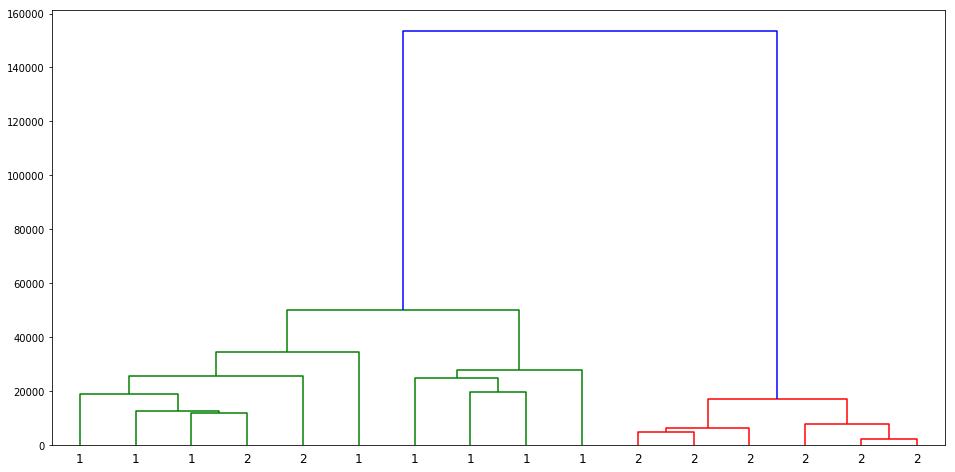

In [5]:
from scgenome import simulation
cn_data, plinkage, plot_data, clustering, prop_correct = (
    simulation.poisson_bicluster(NUM_SAMPLE, NUM_BIN, MAX_CN, ALPHA, init_lambdas=(1, 3), jump_lambdas=(1, 0.1), seeds=(1, 3), noise_seed=2))

display(plinkage[["i","j","r_merge","dist","merge_count"]])
display(cn_data.head())


cell_id_labels = cl_cell_ids.str[2]
fig = plt.figure(figsize=(16, 8))
dend = dendrogram(plot_data, labels=cell_id_labels)

In [18]:
from scgenome.simulation import many_poisson_bicluster
foo = many_poisson_bicluster(3, [4], [50,100], [7], [0.1,0.3], [(3,1)], [(1, 0.1)])

/Users/massoudmaher/Documents/Code/scgenome/scgenome/simulation.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  plinkage["r_merge"] = plinkage["r_merge"].astype("float")
/Users/massoudmaher/Documents/Code/scgenome/scgenome/simulation.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  plinkage["dist"] = -1 * plinkage["r_merge"]


In [19]:
display(foo)

,samples_per_cluster,num_bin,max_cn,alpha,init_lambdas,jump_lambdas,cn_data,plinkage,plot_data,clustering,prop_correct
0,4,50,7,0.1,"(3, 1)","(1, 0.1)",chr bin cell_id state start end clu...,i j r_merge merge_count d...,"[[4.0, 6.0, 90.14359834740472, 2.0], [8.0, 7.0...",sample_inds cell_id exp_cl obs_cl 0 ...,0.750
1,4,50,7,0.3,"(3, 1)","(1, 0.1)",chr bin cell_id state start end clu...,i j r_merge merge_count d...,"[[6.0, 7.0, 235.78160722832496, 2.0], [4.0, 5....",sample_inds cell_id exp_cl obs_cl 0 ...,0.750
2,4,100,7,0.1,"(3, 1)","(1, 0.1)",chr bin cell_id state start end clu...,i j r_merge merge_count d...,"[[5.0, 6.0, 805.4746151373353, 2.0], [4.0, 7.0...",sample_inds cell_id exp_cl obs_cl 0 ...,0.875
3,4,100,7,0.3,"(3, 1)","(1, 0.1)",chr bin cell_id state start end clu...,i j r_merge merge_count d...,"[[6.0, 7.0, 974.6813443631833, 2.0], [4.0, 5.0...",sample_inds cell_id exp_cl obs_cl 0 ...,0.875
0,4,50,7,0.1,"(3, 1)","(1, 0.1)",chr bin cell_id state start end clu...,i j r_merge merge_count d...,"[[6.0, 7.0, 341.6087721306324, 2.0], [4.0, 5.0...",sample_inds cell_id exp_cl obs_cl 0 ...,0.750
1,4,50,7,0.3,"(3, 1)","(1, 0.1)",chr bin cell_id state start end clu...,i j r_merge merge_count dis...,"[[6.0, 7.0, 882.3065508422301, 2.0], [2.0, 4.0...",sample_inds cell_id exp_cl obs_cl 0 ...,0.625
2,4,100,7,0.1,"(3, 1)","(1, 0.1)",chr bin cell_id state start end clu...,i j r_merge merge_count d...,"[[4.0, 5.0, 1146.3462136767882, 2.0], [6.0, 7....",sample_inds cell_id exp_cl obs_cl 0 ...,0.500
3,4,100,7,0.3,"(3, 1)","(1, 0.1)",chr bin cell_id state start end clu...,i j r_merge merge_count d...,"[[5.0, 7.0, 1082.1482774875847, 2.0], [4.0, 8....",sample_inds cell_id exp_cl obs_cl 0 ...,0.625
0,4,50,7,0.1,"(3, 1)","(1, 0.1)",chr bin cell_id state start end clu...,i j r_merge merge_count d...,"[[5.0, 7.0, 392.82660534815716, 2.0], [4.0, 6....",sample_inds cell_id exp_cl obs_cl 0 ...,0.500
1,4,50,7,0.3,"(3, 1)","(1, 0.1)",chr bin cell_id state start end clu...,i j r_merge merge_count dis...,"[[4.0, 5.0, 809.7387636282604, 2.0], [8.0, 6.0...",sample_inds cell_id exp_cl obs_cl 0 ...,0.750


['1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '2', '2']


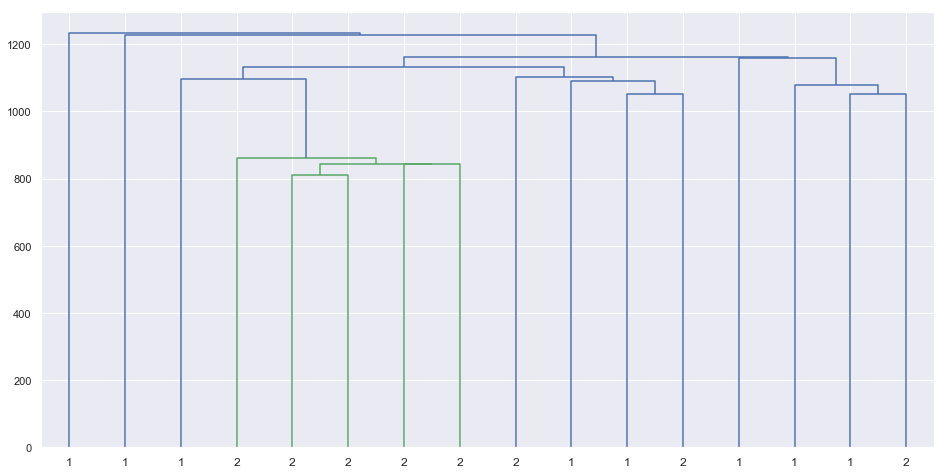

In [50]:
sl = linkage(cn_mat, metric="cityblock")
mylabels = list(pd.Series(cell_ids).str[2])
print(list(mylabels))
#sl[:,2] = np.log(sl[:,2])
fig = plt.figure(figsize=(16, 8))
g = dendrogram(sl, labels=mylabels)

In [54]:
from scipy.cluster.hierarchy import to_tree
display(sl)
to_tree(sl).id

array([[1.000e+01, 1.200e+01, 8.110e+02, 2.000e+00],
       [8.000e+00, 1.400e+01, 8.430e+02, 2.000e+00],
       [1.600e+01, 1.700e+01, 8.440e+02, 4.000e+00],
       [1.100e+01, 1.800e+01, 8.600e+02, 5.000e+00],
       [4.000e+00, 1.500e+01, 1.051e+03, 2.000e+00],
       [1.000e+00, 1.300e+01, 1.052e+03, 2.000e+00],
       [7.000e+00, 2.100e+01, 1.080e+03, 3.000e+00],
       [3.000e+00, 2.000e+01, 1.091e+03, 3.000e+00],
       [2.000e+00, 1.900e+01, 1.097e+03, 6.000e+00],
       [9.000e+00, 2.300e+01, 1.101e+03, 4.000e+00],
       [2.400e+01, 2.500e+01, 1.133e+03, 1.000e+01],
       [6.000e+00, 2.200e+01, 1.158e+03, 4.000e+00],
       [2.600e+01, 2.700e+01, 1.161e+03, 1.400e+01],
       [0.000e+00, 2.800e+01, 1.228e+03, 1.500e+01],
       [5.000e+00, 2.900e+01, 1.233e+03, 1.600e+01]])

30